### Performance Evaluation: The mAP Score ###

In [1]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

# PyTorch
import torch
from torchvision import ops

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh, xywh2xyxy, plot_boxes
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform
from computervision.performance import DetectionMetrics
from computervision.inference import DETRInference

print(f'Project version: {computervision.__version__}')
print(f'Authors: {computervision.__authors__}')
print(f'Python version:  {sys.version}')

Project version: v0.0.2
Authors: The Core for Computational Biomedicine at Harvard Medical School
https://dbmi.hms.harvard.edu/about-dbmi/core-computational-biomedicine
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


In [3]:
# ROBOFLOW DATA
dataset = 'dataset_object_roboflow_240930'
image_dir = os.path.join(os.environ.get('DATA'), dataset)
df_file_name = 'roboflow_240930_dset.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

# Let's get rid of the rows where we do not have positions
# And select the test data
df = df.loc[(~df[pos_col].isnull()) & (df['dset'] == 'test')].\
    reset_index(drop=True)
display(df.head(2))
df_file_list = [os.path.join(image_dir, file_name) for file_name in df[file_col].unique()]
# Check the test data
checked = [is_image(file) for file in df_file_list]
assert np.sum(checked) == len(df_file_list)
print(f'Using {len(checked)} images from the Roboflow data set')
print(f'Annotations: {df.shape[0]}')

,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id
0,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[0.0, 2.0, 89.539, 213.0]",tooth 23,teeth,11,8f6469e5a9_454
1,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[73.0, 3.0, 195.099, 219.0]",tooth 24,teeth,12,8f6469e5a9_455


Using 48 images from the Roboflow data set
Annotations: 444


In [13]:
# Create predictions for this data set
model_name = 'rtdetr_roboflow_251005_01'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
model_json_name = f'{model_name}.json'
model_json_file = os.path.join(model_dir, model_json_name)

# Load model parameters
with open(model_json_file, mode='r') as fl:
    model_parameters = json.load(fl)
display(model_parameters.keys())
model_info = model_parameters.get('model_info')

checkpoint_name = 'checkpoint-3800'
checkpoint = os.path.join(model_dir, checkpoint_name)

detr = DETRInference(device=device, checkpoint_path=checkpoint, batch_size=4)
# Convert the model outputs to the class labels (positions)
id2label = detr.model.config.id2label


# PyTorch Dataset
im_width = model_parameters.get('model_info')['im_width']
im_height = model_parameters.get('model_info')['im_height']
transforms = AugmentationTransform(im_width=im_width, im_height=im_height).\
                get_transforms(name='val')
print(*transforms, sep='\n')

dataset = DETRdataset(data=df.copy(),
                      image_processor=detr.processor,
                      image_dir=image_dir,
                      file_name_col=file_col,
                      label_id_col=None,
                      bbox_col=None,
                      transforms=transforms)

# Let's create an image id so we can match the predictions to the original inputs
file_list = dataset.file_list
file_name_list = [os.path.basename(file) for file in file_list]
file2id = dict(zip(file_name_list, range(len(file_name_list))))
df = df.assign(image_id=df[file_col].apply(lambda file: file2id.get(file)))
display(df.head(2))

dict_keys(['model_info', 'id2label', 'training_args', 'processor_params', 'bbox_format'])

NoOp(p=1.0)
AutoContrast(p=1.0, cutoff=0.0, ignore=None, method='cdf')
CLAHE(p=1.0, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id,image_id
0,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[0.0, 2.0, 89.539, 213.0]",tooth 23,teeth,11,8f6469e5a9_454,0
1,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[73.0, 3.0, 195.099, 219.0]",tooth 24,teeth,12,8f6469e5a9_455,0


In [14]:
# Run the predictions
threshold = 0.05
pred_df = detr.predict_on_dataset(dataset=dataset, threshold=threshold)

# We need the position labels
pred_df[pos_col] = pred_df['category_id'].apply(lambda cl: id2label.get(cl))
pred_df = pred_df.astype({pos_col: int})
display(pred_df.head(2))

Predicting batch 10 of 12.


,image_id,image_width,image_height,batch,category_id,bbox,score,area,pos
0,0,640,480,0,18,"[283, 184, 356, 175]",0.983717,62300,19
1,0,640,480,0,19,"[143, 185, 292, 174]",0.97639,50808,20


### Classify the predictions ###

In [29]:
# Image
image_id_list = sorted(pred_df['image_id'].unique())
print(len(image_id_list))
idx = 10
image_id = image_id_list[idx]

df_id = df.loc[df['image_id'] == image_id]
pred_df_id = pred_df.loc[pred_df['image_id'] == image_id]

# Load the image
file = os.path.join(image_dir, df_id[file_col].tolist()[0])
im = ImageData().load_image(file)
xlim = (0, im.shape[1])
ylim = (0, im.shape[0])

# Ground truth classes and bounding boxes
pos_list = df_id[pos_col].tolist()
bbox_list = df_id[bbox_col].tolist()
bbox_list = [clipxywh(list(bbox), xlim=xlim, ylim=ylim, decimals=0) for bbox in bbox_list]

# Predicted bounding boxes            
pred_pos_list = pred_df_id[pos_col].tolist()
pred_bbox_list = pred_df_id['bbox'].tolist()
score_list = pred_df_id['score'].tolist()
pred_bbox_list = [clipxywh(list(bbox), xlim=xlim, ylim=ylim, decimals=0) for bbox in pred_bbox_list]

missed, cl_df = DetectionMetrics(im_width=im.shape[1], im_height=im.shape[0]).\
    classify_predictions(
    true_labels=pos_list,
    true_bboxes=bbox_list,
    pred_labels=pred_pos_list,
    pred_bboxes=pred_bbox_list,
    iou_threshold=0.5)

# Add the scores
cl_df = cl_df.assign(score=score_list)
cl_df = cl_df.sort_values(by=['pred_label', 'score'], ascending=False)

print(f'Ground truth positions:  {sorted(pos_list)}')
print(f'Predicted positions:     {sorted(pred_pos_list)}')
print(f'Missed predictions (FN): {missed}')
print('IOU classification for this image')
display(cl_df)

48
Ground truth positions:  [2, 3, 4, 5, 6, 28, 29, 30, 31]
Predicted positions:     [2, 3, 4, 5, 6, 28, 30, 31]
Missed predictions (FN): [29]
IOU classification for this image


,pred_label,TP,IoU,FN,duplicate_TP,score
4,31,0,0.276249,1,False,0.072739
3,30,0,0.172348,1,False,0.078309
6,28,0,0.148995,1,False,0.057048
0,6,1,0.687073,1,False,0.115364
5,5,1,0.728851,1,False,0.067335
2,4,1,0.767872,1,False,0.079910
7,3,1,0.733324,1,False,0.054960
1,2,1,0.699919,1,False,0.113400


True bbox: [25, 4, 189, 261]


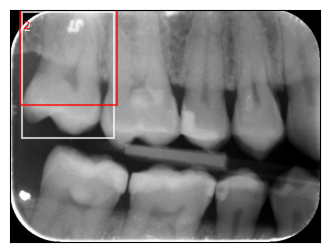

Predicted position: [2]
Predicted bounding boxes for pos 2: 1
IoU NP: 0.7010131905945326
IoU PT: 0.6999189853668213
IOU PT: [0.6999189853668213]
True bbox: [187, 1, 353, 290]


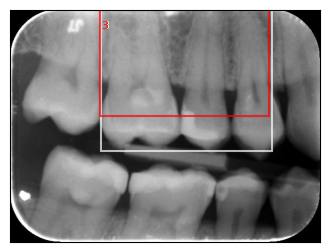

Predicted position: [3]
Predicted bounding boxes for pos 3: 1
IoU NP: 0.7342055066376371
IoU PT: 0.7333236336708069
IOU PT: [0.7333236336708069]
True bbox: [352, 0, 288, 292]


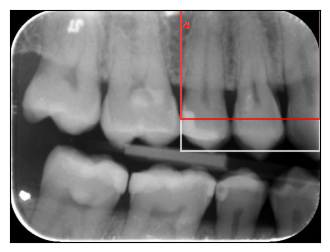

Predicted position: [4]
Predicted bounding boxes for pos 4: 1
IoU NP: 0.7686620924217911
IoU PT: 0.7678724527359009
IOU PT: [0.7678724527359009]
True bbox: [458, 1, 182, 312]


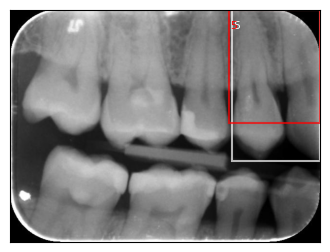

Predicted position: [5]
Predicted bounding boxes for pos 5: 1
IoU NP: 0.7297172946168397
IoU PT: 0.7288508415222168
IOU PT: [0.7288508415222168]
True bbox: [559, 4, 81, 314]


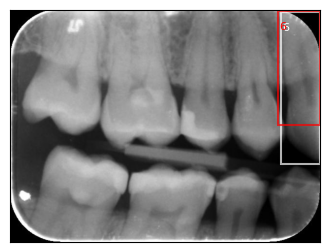

Predicted position: [6]
Predicted bounding boxes for pos 6: 1
IoU NP: 0.6884018661169578
IoU PT: 0.6870733499526978
IOU PT: [0.6870733499526978]
True bbox: [534, 323, 106, 157]


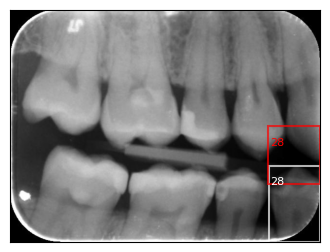

Predicted position: [28]
Predicted bounding boxes for pos 28: 1
IoU NP: 0.15250612435354047
IoU PT: 0.14899487793445587
IOU PT: [0.14899487793445587]
True bbox: [423, 327, 217, 153]


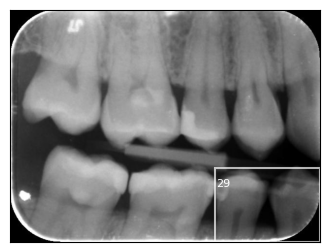

Predicted position: []
Predicted bounding boxes for pos 29: 0
IoU NP: nan
IoU PT: nan
IOU PT: []
True bbox: [228, 317, 412, 163]


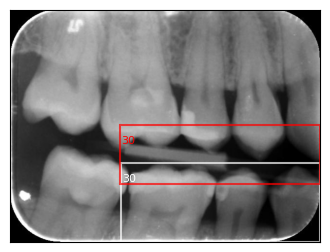

Predicted position: [30]
Predicted bounding boxes for pos 30: 1
IoU NP: 0.17572781828100978
IoU PT: 0.17234769463539124
IOU PT: [0.17234769463539124]
True bbox: [45, 281, 246, 199]


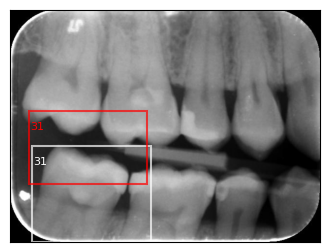

Predicted position: [31]
Predicted bounding boxes for pos 31: 1
IoU NP: 0.278787699059933
IoU PT: 0.2762485444545746
IOU PT: [0.2762485444545746]


In [30]:
# Select a class
for pos in sorted(pos_list):

    # WE NEED TO MAKE SURE THAT THE BOUNDING BOXES ARE CLIPPED TO THE SIZE OF THE IMAGE
    # pos = 6
    df_pos = df.loc[(df['image_id'] == image_id) & (df[pos_col] == pos)]
    bbox = list(df_pos[bbox_col].tolist()[0])
    bbox = clipxywh(bbox, xlim=xlim, ylim=ylim, decimals=0)
    print(f'True bbox: {bbox}')
    
    pred_df_pos = pred_df.loc[(pred_df['image_id'] == image_id) & (pred_df[pos_col] == pos)]
    pred_pos_list = pred_df_pos[pos_col].tolist()
    pred_bbox_list = pred_df_pos['bbox'].tolist()
    pred_bbox_list = [clipxywh(list(pbox), xlim=xlim, ylim=ylim, decimals=0) for pbox in pred_bbox_list]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = plot_boxes(image=im, box_list=[bbox], label_list=[pos], ax=ax, color='w')
    ax = plot_boxes(image=im, box_list=pred_bbox_list, label_list=pred_pos_list, ax=ax, color='r')    
    
    plt.show()
    
    
    
    if len(pred_bbox_list) > 0:
        iou_np = DetectionMetrics.compute_iou(bbox_1=bbox, bbox_2=pred_bbox_list[0], method='np')
        iou_pt = DetectionMetrics.compute_iou(bbox_1=bbox, bbox_2=pred_bbox_list[0], method='pt')
    else:
        iou_np = np.nan
        iou_pt = np.nan
        
    iou_list = [DetectionMetrics.compute_iou(bbox_1=bbox, bbox_2=pbox, bbox_format='xywh', method='pt') \
                for pbox in pred_bbox_list]
    
    print(f'Predicted position: {pred_pos_list}')
    print(f'Predicted bounding boxes for pos {pos}: {len(pred_bbox_list)}')
    print(f'IoU NP: {iou_np}')
    print(f'IoU PT: {iou_pt}')
    print(f'IOU PT: {iou_list}')

In [32]:
display(cl_df)
print(f'Positions that were missed: {missed}')

,pred_label,TP,IoU,FN,duplicate_TP,score
4,31,0,0.276249,1,False,0.072739
3,30,0,0.172348,1,False,0.078309
6,28,0,0.148995,1,False,0.057048
0,6,1,0.687073,1,False,0.115364
5,5,1,0.728851,1,False,0.067335
2,4,1,0.767872,1,False,0.079910
7,3,1,0.733324,1,False,0.054960
1,2,1,0.699919,1,False,0.113400


Positions that were missed: [29]
